# Learning PyTorch: Binary Classification & Simple Neural Net

This notebook demonstrates:
1. A single-layer “logistic regression” model on a non-linear 2D dataset.
2. A single-layer “logistic regression” model on a 3D non-separable dataset, with a plotted decision plane.
3. A small multi-layer perceptron (MLP) on the 2D “moons” dataset, with decision-boundary visualization.

We use PyTorch, scikit-learn, NumPy & Matplotlib.

## 1. Setup & Imports


In [ ]:
# PyTorch Core
# %matplotlib widget    (UNCOMMENT THIS IF YOU WANT TO INTERACT WITH THE GRAPHS)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# NumPy & Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# 3D Plotting
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn for data and preprocessing
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



## 2. 2D Non-Linear “Moons” Dataset + Logistic Regression


First we wrap NumPy data in PyTorch's Dataset/DataLoader.

### Key PyTorch Data Components

- **Tensor**: An n-dimensional array (like a NumPy array) that holds raw data or model parameters in PyTorch.  
- **Dataset**: An abstract, indexable collection that defines how to fetch individual samples and their labels via `__len__` and `__getitem__`.  
- **TensorDataset**: A simple `Dataset` wrapper that binds together one or more equal-length tensors so each `__getitem__` returns a tuple of corresponding elements.  
- **DataLoader**: A utility that takes a `Dataset` and provides batching, shuffling, and (optionally) parallel data loading for efficient training loops.  


#### Converting NumPy arrays to PyTorch tensors

- **`torch.from_numpy(X).float()`**  
  - `torch.from_numpy(X)`: creates a PyTorch tensor that **shares memory** with the NumPy array `X` (no data copy).  
  - `.float()`: casts the tensor to 32-bit floating point (`torch.float32`), which is the default dtype for most models and optimizers.

- **`torch.tensor(X, dtype=…, device=…)`**  
  - Always **copies** data from `X` (NumPy array or Python sequence) into a new tensor.  
  - You can specify the target dtype (e.g. `torch.float32`, `torch.int64`) and device (e.g. `"cuda"`).

- **`torch.as_tensor(X, dtype=…)`**  
  - Like `from_numpy`, it **avoids copies** when possible, but will copy if the dtype or device doesn’t match.  
  - Useful when you want zero-copy conversion but also need to change dtype in one call.

- **`.long()`, `.double()`, `.byte()`**  
  - Shorthand for casting to specific dtypes:  
    - `.long()` → `torch.int64`  
    - `.double()` → `torch.float64`  
    - `.byte()` → `torch.uint8`

- **`.requires_grad_()`**  
  - In-place method to enable gradient tracking on a tensor so that operations on it get recorded for automatic differentiation.

```python
import numpy as np
import torch

X = np.random.rand(5, 2)

# Zero-copy + cast to float32
t1 = torch.from_numpy(X).float()      

# Copy + specify dtype & device
t2 = torch.tensor(X, dtype=torch.float32, device="cuda")  

# Zero-copy when possible, with dtype conversion
t3 = torch.as_tensor(X, dtype=torch.float32)               


In [ ]:
def make_dataloader(X, y, batch_size=32, shuffle=True):
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).float().unsqueeze(1)  # shape (N,) -> shape (N,1)
    ds = TensorDataset(X_tensor, y_tensor)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# Example: 2D moons
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

train_loader2d = make_dataloader(X_train, y_train, batch_size=64)
test_loader2d  = make_dataloader(X_test,  y_test,  batch_size=64, shuffle=False)


Now we define the model:

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.linear(x))


Now we define the training loop:

In [ ]:
model2d = LogisticRegression(2).to(device)
criterion2d = nn.BCELoss()  # Binary Cross Entropy
optimizer2d = optim.SGD(model2d.parameters(), lr=0.1) # Stochastic Gradient Descent. model.parameters() tells it which weight to update, and lr is the learning rate.

def train_epoch(model, loader, criterion, optimizer): # this defines what one epoch looks like
    model.train() # puts model in training mode
    total_loss, total_acc = 0, 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad() # clear any gradients from previous batch
        preds = model(X_batch) # forward pass
        loss = criterion(preds, y_batch)
        loss.backward() # computes gradient of the loss wrt model parameters
        optimizer.step() # applies gradient
        total_loss += loss.item() * X_batch.size(0)
        total_acc   += ((preds > 0.5) == y_batch).sum().item()
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset) # return average loss and accuracy over the full dataset

def eval_epoch(model, loader, criterion): # evaluation loop for validation
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():  # evaluation mode
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            total_acc   += ((preds > 0.5) == y_batch).sum().item()
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

# Run training
history2d = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(1, 101):
    tr_loss, tr_acc = train_epoch(model2d, train_loader2d, criterion2d, optimizer2d)
    va_loss, va_acc = eval_epoch(model2d, test_loader2d,  criterion2d)
    history2d['train_loss'].append(tr_loss)
    history2d['train_acc'].append(tr_acc)
    history2d['val_loss'].append(va_loss)
    history2d['val_acc'].append(va_acc)


In [ ]:
print("Final accuracy is " + str(history2d.get('val_acc')[-1]))

Final accuracy is 0.86


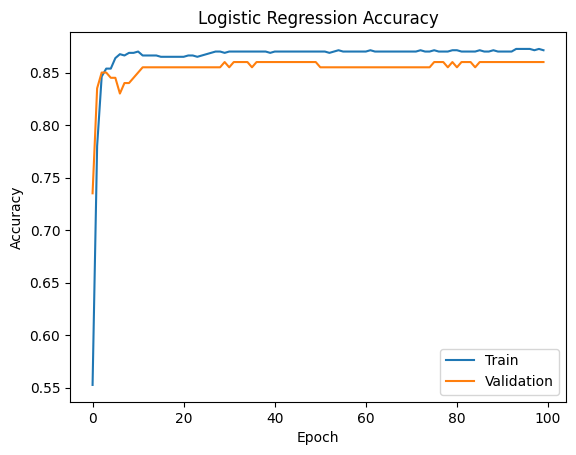

In [ ]:
plt.plot(history2d['train_acc'], label='Train')
plt.plot(history2d['val_acc'],   label='Validation')
plt.title("Logistic Regression Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


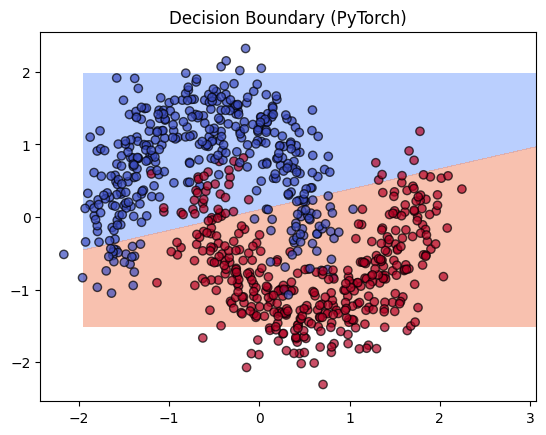

In [ ]:
# Create a grid
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 300),
                       np.linspace(x2_min, x2_max, 300))
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_scaled = scaler.transform(grid)
grid_tensor = torch.from_numpy(grid_scaled).float().to(device)

with torch.no_grad():
    probs = model2d(grid_tensor).cpu().numpy().reshape(xx1.shape)

plt.contourf(xx1, xx2, probs, levels=[0,0.5,1], alpha=0.6, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolor='k', alpha=0.7, cmap='coolwarm')
plt.title("Decision Boundary (PyTorch)")
plt.show()


## 3. Logistic Regression in 3D


In [ ]:
X3d, y3d = make_classification(
    n_samples=1000, n_features=3, n_informative=3,
    n_redundant=0, n_clusters_per_class=1,
    class_sep=0.75, random_state=42
)
X3d_train, X3d_test, y3d_train, y3d_test = train_test_split(X3d, y3d, test_size=0.2, random_state=42)
scaler3d = StandardScaler().fit(X3d_train)
X3d_train_scaled = scaler3d.transform(X3d_train)
X3d_test_scaled  = scaler3d.transform(X3d_test)

train_loader3d = make_dataloader(X3d_train_scaled, y3d_train)
test_loader3d  = make_dataloader(X3d_test_scaled,  y3d_test, shuffle=False)

model3d = LogisticRegression(3).to(device)
criterion3d = nn.BCELoss()
optimizer3d = optim.SGD(model3d.parameters(), lr=0.1)

history3d = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(1, 101):
    tr_loss, tr_acc = train_epoch(model3d, train_loader3d, criterion3d, optimizer3d)
    va_loss, va_acc = eval_epoch(model3d, test_loader3d,  criterion3d)
    history3d['train_loss'].append(tr_loss)
    history3d['train_acc'].append(tr_acc)
    history3d['val_loss'].append(va_loss)
    history3d['val_acc'].append(va_acc)

In [ ]:
print("Final accuracy is " + str(history3d.get('val_acc')[-1]))

Final accuracy is 0.865


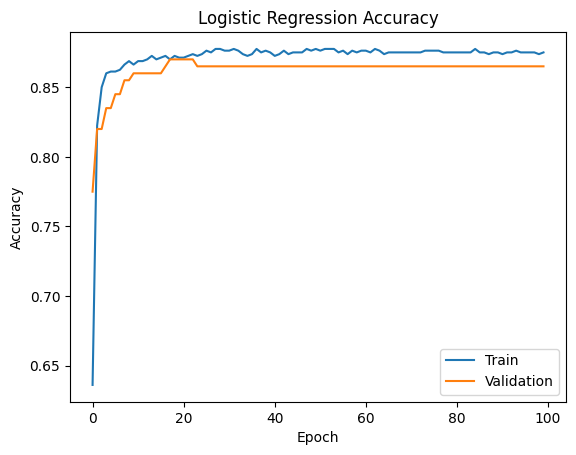

In [ ]:
plt.plot(history3d['train_acc'], label='Train')
plt.plot(history3d['val_acc'],   label='Validation')
plt.title("Logistic Regression Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Plot of the decision boundary:

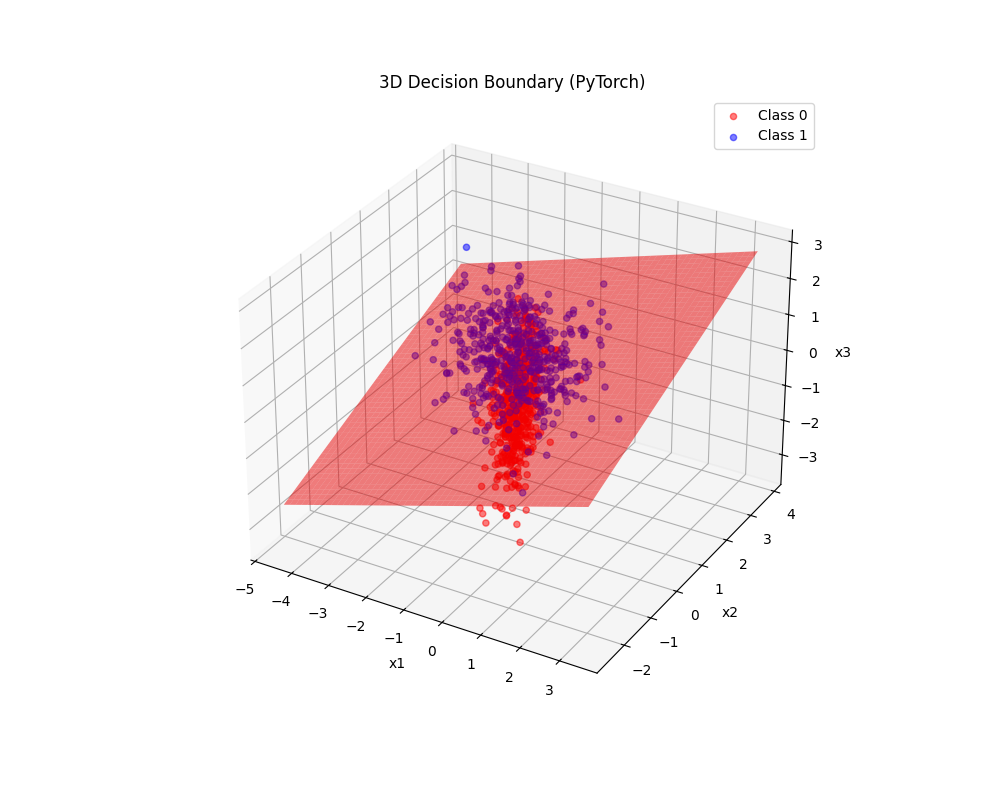

In [ ]:
# get weights & bias
w = model3d.linear.weight.data.cpu().numpy().flatten()  # shape (3,)
b = model3d.linear.bias.data.cpu().item()              # scalar

# build meshgrid in x1-x2
x1_range = np.linspace(X3d[:,0].min()-0.5, X3d[:,0].max()+0.5, 50)
x2_range = np.linspace(X3d[:,1].min()-0.5, X3d[:,1].max()+0.5, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)

# compute x3 from the plane equation
if abs(w[2]) < 1e-6:
    raise ValueError("w[2] is nearly zero; cannot solve for x3")
X3 = (-w[0]*X1 - w[1]*X2 - b) / w[2]

# plot

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X3d[y3d==0, 0], X3d[y3d==0, 1], X3d[y3d==0, 2],
           c='red',   label='Class 0', alpha=0.5)
ax.scatter(X3d[y3d==1, 0], X3d[y3d==1, 1], X3d[y3d==1, 2],
           c='blue',  label='Class 1', alpha=0.5)
ax.plot_surface(X1, X2, X3, alpha=0.5, color='red')

ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('x3')
ax.set_title("3D Decision Boundary (PyTorch)")
ax.legend()
plt.show()

## 4. Neural Network on 2D “Moons” + Decision Boundary


## Neural network

Mostly the same code, but take a look at the model definition.

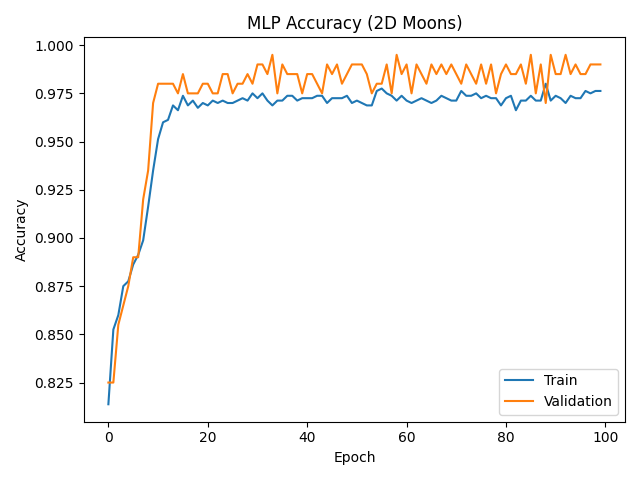

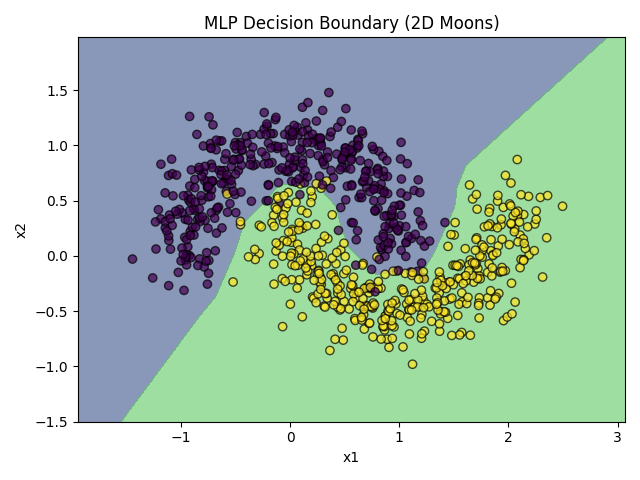

In [ ]:
# 1. Data Preparation
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

train_dataset = TensorDataset(
    torch.from_numpy(X_train_scaled).float(),
    torch.from_numpy(y_train).float().unsqueeze(1)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_scaled).float(),
    torch.from_numpy(y_test).float().unsqueeze(1)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# 2. Model Definition
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 3. Training & Evaluation Functions
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0.0, 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        total_acc  += ((preds > 0.5) == y_batch).sum().item()
    n = len(loader.dataset)
    return total_loss / n, total_acc / n

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            total_acc  += ((preds > 0.5) == y_batch).sum().item()
    n = len(loader.dataset)
    return total_loss / n, total_acc / n

# 4. Training Loop
epochs = 100
history = {'train_acc': [], 'val_acc': []}

for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer)
    va_loss, va_acc = eval_epoch(model, test_loader,  criterion)
    history['train_acc'].append(tr_acc)
    history['val_acc'].append(va_acc)

# 5. Plot Accuracy
plt.figure()
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'],   label='Validation')
plt.title("MLP Accuracy (2D Moons)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Decision Boundary
x1_min, x1_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
x2_min, x2_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300)
)
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_scaled = scaler.transform(grid)
grid_tensor = torch.from_numpy(grid_scaled).float().to(device)

with torch.no_grad():
    probs = model(grid_tensor).cpu().numpy().reshape(xx1.shape)

plt.figure()
plt.contourf(xx1, xx2, probs, levels=[0, 0.5, 1], alpha=0.6)
plt.scatter(
    X_train[:,0], X_train[:,1],
    c=y_train, edgecolor='k', alpha=0.7
)
plt.title("MLP Decision Boundary (2D Moons)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()